# The Battle of the Neighborhoods (Week 1)

### Summary

The main goal of the IBM Applied Data Science Capstone project is to compare various neighborhoods in Toronto, Ontario, CA by exploring them using location data, segmenting them into similar clusters and comparing them based on various aspects such as the services they might provide, or potentially why certain venues are popular or possibly, why people complain about certain venues.

This notebook contains the third 'stage' of the capstone project. It contains the code to obtain the geocoded neighborhood data as well as code to explore the neighborhoods, segment and cluster them using k-means clustering.


### Obtaining Neighborhood Data
Unlike other cities, like New York, Toronto's neighborhood data is not readily available on the Internet in a directly consumable format. However, for this data, a [Wikipedia page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) exists that contains data we can use to divide the city into boroughs and neighborhoods.

First, we get our imports in place. We are using `Pandas`, as well as `Requests` to scrape the page and `BeautifulSoup` for parsing the resulting HTML.

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

To utilize the Wikipedia page, we will need to perform the following steps:
1. Scrape the HTML from the page
2. Parse the page, locate the relevant data in an HTML table and transform it to a Pandas DataFrame
3. Perform some data wrangling to deal with neighborhoods and boroughs that are 'not assigned' in the data and to combine the data in a useful way

The code block below performs the steps and then lists the shape of the resulting DataFrame. Note that I performed some manual data wrangling utilizing SQL Server, to obtain the goal of the final shape of the DataFrame. Also note that the code below makes some key assumptions:
* Wikipedia doesn't change the existence, location, structure or content of the given page
* The HTML page only contains exactly one table with class `wikitable sortable`
* Each row in that HTML table contains data

In [2]:
# Get the HTML from the Wiki page in the assignment
wiki_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

# Create a BeautifulSoup object out of the HTML using the lxml parser
soup = BeautifulSoup(wiki_url, 'lxml')

# From inspection, the table in the page has a class of 'wikitable sortable'
# and is the only such table currently in the document. If one more is added
# this code will fail because pc_table will become a list.
pc_table = soup.find('table', {'class':'wikitable sortable'})

# Get all the rows in the table we found
table_rows = pc_table.find_all('tr')

# Go through all the rows and create a list for each one containing all the
# data elements on that row. We use rstrip() to remove the trailing \n, which
# from inspection is included on the last data item in the row. This code
# assumes that the the text attribute of the row is not None. Each is appended
# to an empty list
l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.rstrip() for tr in td]
    if (len(row) > 0 and row[1] != 'Not assigned'):
        l.append(row)

# Create a Pandas DataFrame from the list we built with appropriately named columns
pc_df = pd.DataFrame(l, columns=['PostalCode', 'Borough', 'Neighborhood'])

# Group the DataFrame by PostalCode and Borough and use the apply method to join
# Neighborhoods together with a comma in between. Create a new DataFrame from the
# result and reset the index
pc_df = pc_df.groupby(by=['PostalCode','Borough'])['Neighborhood'].apply(','.join).to_frame().reset_index()

# We excluded Boroughs that were 'Not assigned', however, from inspection, there is
# exactly one neighborhood that has 'Not assigned' for the neighborhood, Queen's Park.
# For this we update that one row's neighborhood with the value of its borough
pc_df.loc[pc_df.Neighborhood == 'Not assigned', 'Neighborhood'] = pc_df.loc[pc_df.Neighborhood == 'Not assigned', 'Borough']

# Display the first few rows
pc_df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


The resulting DataFrame, based on manual, external validation in a relational database, should have 103 rows.

In [3]:
# The shape of the dataframe, based on external validation, should be (103,3)
print('The resulting DataFrame has {} rows'.format(pc_df.shape[0]))

The resulting DataFrame has 103 rows


### Geocoding Neighborhood Data

Now that we have a DataFrame with the postal code, borough and neighborhoods, we almost have what we need to use the Foursquare API. First, however, we must geocode each postal code so that we can use geographic coordinates in the Foursquare API.

There are a few options available for obtaining latitude and longitude for postal codes. The most reliable option would be the Google Maps API, which provides highly efficient geocoding services, but is no longer free of charge. There is also a Python package called `Geocoder` that utilizes myriad other services, (e.g. ArcGIS, Baidu, Bing, Geocoder.ca, MapQuest, et al) to perform geocoding. One problem with this package, though, is that many times a call to it will return `None`, and so we have to try the call many times, to obtain latitude and longitude, and sometimes we cannot.

Because of the cost associated with Google Maps API and the non-deterministic behavior of `Geocoder` I have chosen to use the text file made available for the capstone project that contains pre-geocoded postal codes, located [here](http://cocl.us/Geospatial_data).

The following code will read the csv from the given location into a DataFrame and then inner join it to the neighborhood DataFrame on postal code. Some care is taken to ensure that the join is truly one-to-one and that each postal code exists in both DataFrames. The resulting DataFrame should have the same 103 rows as before and all rows should have the indicator listed as both (e.g. `_merge == 'both'`). Finally the duplicated join column and the indicator column `_merge` are dropped.

In [4]:
# Read the latitude/longitude csv file from the location provided in the assignment
lat_lon_coords = pd.read_csv('http://cocl.us/Geospatial_data')

# Join the coordinates to the existing DataFrame on PostalCode.  We use a 
# validation of one-to-one which checks if merge keys are unique in both 
# left and right datasets as well as an indicator of the source of the row
# after join.
joined = pd.merge(pc_df, lat_lon_coords, how='inner', left_on='PostalCode', 
                  right_on='Postal Code', validate='1:1', indicator=True)

# We should end up with a shape that is 4 columns wider than before but
# with the same 103 rows the original had, os it should be (103, 7).
# The indicator column should be both for all rows.
print('The joined DataFrame has ' + 
      str(joined.shape[0]) + ' rows, ' +
      str(joined[(joined['_merge'] != 'both')].size) +
      ' of which with an indicator that is not \'both\'')

# We can now drop the unnecessary and/or duplicated columns in the joined DataFrame
# and display the first few rows for inspection.
joined.drop(['Postal Code', '_merge'], axis=1, inplace=True)
joined.head()

The joined DataFrame has 103 rows, 0 of which with an indicator that is not 'both'


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Visualizing Toronto Neighborhoods

Next we are going to visualize our postal codes superimposed on a map of Toronto, Ontario, CA. 

First, we need to get our imports in place. We are using `matplotlib` for various plots and plot aspects, `numpy` for some basic array-related functionality, `folium` for drawing maps and `Nominatim` to lookup Toronto's coordinates.

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import folium
from geopy.geocoders import Nominatim

Now, geocode Toronto, using `Nominatim`.

In [6]:
# Get the latitude and longitude for Toronto, Ontario, CA
address = 'Toronto, Ontario, CA'

# Use the geolocator to get the latitude and longitude and display them
geolocator = Nominatim(user_agent='jrf_capstone')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto, Ontario, CA are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto, Ontario, CA are 43.653963, -79.387207.


Here we use `Folium` to create a map of Toronto with markers for each postal code.

In [7]:
# Create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# Now add markers for each postal code to the map
for lat, lon, borough, neighborhood in zip(joined['Latitude'], joined['Longitude'], joined['Borough'], joined['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label)
    folium.CircleMarker(
        location=[lat, lon],
        popup=label,
        radius=5,
        color='#377ca8',
        weight=2,
        fill_color='#4682b4',
        fill_opacity=0.5).add_to(map_toronto)

# Display the map
map_toronto

### Exploring Toronto with Foursquare

To start exploring these neighborhoods and boroughs we will be using the Foursquare API. First, we will explore a single postal code to get a feel for the kind of data we can obtain from the API. Then we will analyze our neighborhood data, and use the Foursquare API to obtain the top venues for each postal code, so that we can use that data to segment and cluster the neighborhoods based on their top venues.

After getting our final imports in place, we define a few utility functions that will be used in the rest of this exercise.  We borrow the `get_category_type` function from the k-Means Clustering lab so we can easily extract the category from results returned by the API. Also, we define a function to return the JSON response from the `venues/explore` request, because all the requests we are using here will go through the same API method. Note that we are not utilizing the radius parameter in the call because the Foursquare API will decide on an appropriate radius based on the density of venues in the requested location. Next, we adapt a function from the k-Means Clustering lab so that we can perform lookups on groups of locations and return the results in a more useful format, namely a pandas DataFrame. Lastly, we borrow the `return_most_common_venues` from the k-Means Clustering lab so we can sort columns by mean frequency and return the top 10 most frequent venues for a neighborhood.

In [8]:
# Pandas for some json wrangling and sklearn KMeans for clustering
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans

def get_category_type(row):
    '''
    Returns the category of a venue from a row of data returned from 
    Foursquare, or None if one cannot be found
    
    Keyword Arguments:
    row -- the Pandas DataFrame row from which to extract the category
    ''' 
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


def explore_location(lat, lon, limit=100):
    '''
    Utilizes the Foursquare API to return top 100 venues near the given coordinates
    
    Keyword Arguments:
    lat -- the latitude of the location
    lon -- the longitude of the location
    limit -- The optional limit on the number of results. Default is 100
    '''
    CLIENT_ID = '<<removed>>' 
    CLIENT_SECRET = '<<removed>>'
    VERSION = '20190101'
    
    # Get the top 100 venues in this postal code from the Foursquare API and transform
    # the results into a DataFrame. We are excluding radius from the request, as the API
    # will suggest a radius based on the density of venues in the area    
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lon, 
        limit)
    return requests.get(url).json()

def getNearbyVenues(names, latitudes, longitudes):
    '''
    Uses the Foursquare API to get the top 100 venues near the given coordinates
    
    Keyword Arguments
    names -- A sequence of names for display purposes
    latitudes -- A sequence of latitudes to lookup
    longitudes -- A sequence of longitudes to lookup
    '''     
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        results = explore_location(lat, lng)
        
        # The actual results are in the items array of groups
        groups = results['response']['groups'][0]['items']
        
        # Return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in groups])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def return_most_common_venues(row, num_top_venues=10):
    '''
    Returns the requested number of top results from a pandas DataFrame row of numerical values
    
    Keyword Arguments:
    row -- The DataFrame row from which to obtain the top results
    num_top_venues -- The number of items to return. Default value is 10.
    '''
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### A Visit to West Toronto

Having never visited Toronto, I wanted to explore one neighborhood that I've read about, Liberty Village. Like parts of Denver, CO and my hometown of Golden, historic buildings have been converted into lofts or restaurants and bars, and lots of tech companies, startups, and other businesses have set up shop there. Unfortunately, that neighborhood doesn't exist in our neighborhood DataFrame, but, based on a little research and looking at some maps, the closest neighborhoods are Little Portugal and Trinity in West Toronto with postal code M6J.

So, we will locate M6J in our joined dataset, and use its latitude and longitude to query Foursquare to explore the neighborhood. 

In [9]:
# Retrieve the desired postal code from the DataFrame as well as the 
# latitude and longitude. We also reset the index for simplicity
m6j_data = joined.loc[joined['PostalCode'] == 'M6J'].reset_index()
m6j_lat = m6j_data.loc[0, 'Latitude']
m6j_lon = m6j_data.loc[0, 'Longitude']

results = explore_location(m6j_lat, m6j_lon)

Now we are ready to clean the JSON and structure it into a DataFrame, borrowing additional code from the k-Means Clustering lab to filter columns we need for the analysis, obtain the categories for venues and renaming columns.

In [10]:
# Get the venues from the results and flatten the json into a DataFrame
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

# Filter columns we are interested in for later use
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# Filter the category for each row by using our custom function across all rows
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# Clean columns by removing any prefixes from all the column names
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

# Show some of the data
print('{} venues were returned by Foursquare. The top 5 appear below'.format(nearby_venues.shape[0]))
nearby_venues.head()

100 venues were returned by Foursquare. The top 5 appear below


,name,categories,lat,lng
0,Bellwoods Brewery,Brewery,43.647097,-79.419955
1,Pizzeria Libretto,Pizza Place,43.648979,-79.420604
2,OddSeoul,Korean Restaurant,43.646192,-79.419601
3,Foxley Bistro,Asian Restaurant,43.648643,-79.420495
4,Bang Bang Ice Cream & Bakery,Ice Cream Shop,43.646246,-79.419553


Let's get a feel for what kinds of venues are in West Toronto by displaying a bar chart of the top 10 venue categories.

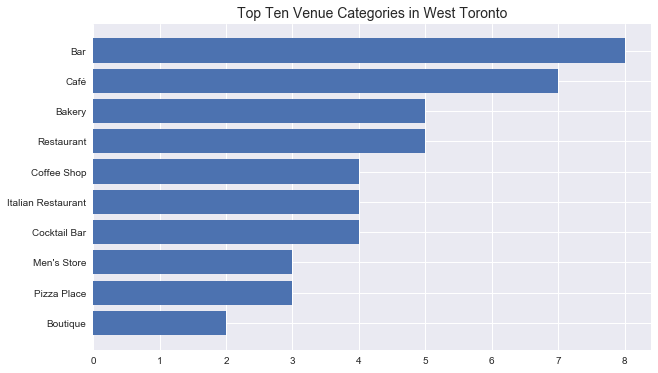

In [11]:
# Use the seaborn stylesheeet for all plots
plt.style.use('seaborn')

# Get the counts of venues by category and choose the top 10 from the list. We
# have to sort these twice because of what I think is a bug in barh where you
# can't specify the order the bars appear in.
cats = nearby_venues.groupby(['categories'], as_index=False).size().to_frame('count').reset_index()
cats.sort_values(by=['count'], ascending=False, inplace=True)
cats.set_index('categories', inplace=True)
cats_top10 = cats[:10].sort_values(by=['count'], ascending=True)

# Generate a horizontal bar graph of the top 10 venue categories. This code
# was adapted from my own peer-reviewed final project for Data Visualization 
# with Python
index = np.arange(10)
bar_width = 0.8

# We are using the artist layer here to create the bar chart. 
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(index, list(cats_top10['count']), bar_width, 
                label=cats_top10.columns[0])

# Remove all but the bottom axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Use the indexed category values as the y tick labels and make sure they
# all appear by setting the yticks to the range that covers our top 10
ax.set_yticks(index)
ax.set_yticklabels(cats_top10.index.values, fontsize=10)

# Set a title
ax.set_title('Top Ten Venue Categories in West Toronto', fontdict={'fontsize': 14}) 

# Show the plot
plt.show()

### Exploring All Toronto

We can repeat parts of the above process for all our Toronto postal codes. The code below, borrowed from the k-Means Clustering lab, uses our utility functions to obtain the top 100 venues for each postal code.

In [12]:
print("Retrieving Foursquare data for all neighborhoods. This process can take a couple of minutes.")
toronto_venues = getNearbyVenues(names=joined['Neighborhood'], 
                                 latitudes=joined['Latitude'], 
                                 longitudes=joined['Longitude'])
print("Retrieved Foursquare data for all neighborhoods")

Retrieving Foursquare data for all neighborhoods. This process can take a couple of minutes.
Retrieved Foursquare data for all neighborhoods


We can see from the shape of the results grouped by neighborhood that we received results for all neighborhoods (i.e. we have 103 rows).

In [13]:
tvg = toronto_venues.groupby('Neighborhood').count()
tvg.shape

(103, 6)

Now, lets get some additional information about the DataFrame of Toronto venues, such as its overall shape, the number of unique categories and what some of its data look like.

In [14]:
print('The result has {} rows and {} columns'.format(toronto_venues.shape[0], toronto_venues.shape[1]))
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))
toronto_venues.head()

The result has 10174 rows and 7 columns
There are 331 unique categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Toronto Pan Am Sports Centre,43.790623,-79.193869,Athletics & Sports
1,"Rouge,Malvern",43.806686,-79.194353,African Rainforest Pavilion,43.817725,-79.183433,Zoo Exhibit
2,"Rouge,Malvern",43.806686,-79.194353,Toronto Zoo,43.820582,-79.181551,Zoo
3,"Rouge,Malvern",43.806686,-79.194353,Polar Bear Exhibit,43.823372,-79.185145,Zoo
4,"Rouge,Malvern",43.806686,-79.194353,Australasia Pavillion,43.822563,-79.183286,Zoo Exhibit


##### Anomaly Corrections in Location Data

One interesting thing to note is that for some postal codes, the Foursquare API returns venues that are, themselves, categorized as neighborhoods. Since this will complicate things later on, when we try to add in our neighborhood names, we are going to modify these venue categories to `district`.

In [15]:
toronto_venues.loc[toronto_venues['Venue Category'] == 'Neighborhood', 'Venue Category'] = 'District'
toronto_venues.loc[toronto_venues['Venue Category'] == 'District']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
68,"Rouge,Malvern",43.806686,-79.194353,Highland Creek,43.790281,-79.173703,District
157,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Highland Creek,43.790281,-79.173703,District
274,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Highland Creek,43.790281,-79.173703,District
1674,Upper Rouge,43.836125,-79.205636,Highland Creek,43.790281,-79.173703,District
4185,"The Beaches West,India Bazaar",43.668999,-79.315572,Leslieville,43.662070,-79.337856,District
4238,Studio District,43.659526,-79.340923,Leslieville,43.662070,-79.337856,District
5663,Central Bay Street,43.657952,-79.387383,Downtown Toronto,43.653232,-79.385296,District
5745,"Adelaide,King,Richmond",43.650571,-79.384568,Downtown Toronto,43.653232,-79.385296,District
5835,"Harbourfront East,Toronto Islands,Union Station",43.640816,-79.381752,Harbourfront,43.639526,-79.380688,District
6767,"CN Tower,Bathurst Quay,Island airport,Harbourf...",43.628947,-79.394420,Harbourfront,43.639526,-79.380688,District


### Analyzing Neighborhoods

We are now ready to begin analyzing our neighborhoods so we can later start building clusters.

The first thing we will do is to utilize *one-hot encoding* which converts the venue category variable into a series of 'dummy' variables, each containing 1 or 0 that are more suitable for segmenting and clustering our neighborhoods. We will also add back in the missing neighborhood column to our DataFrame.  The code block below was borrowed from the k-Means Clustering lab, as well.

In [16]:
# Perform one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# Move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

And lets examine the new DataFrame size

In [17]:
toronto_onehot.shape

(10174, 332)

Next, we group the rows by neighborhood and take the mean of the frequency of occurrence of each category

In [18]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head(10)

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,...,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,"Adelaide,King,Richmond",0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.040000,0.0,...,0.000000,0.00,0.0,0.01,0.00,0.01,0.0,0.00,0.0,0.0
1,Agincourt,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,...,0.020000,0.00,0.0,0.00,0.01,0.00,0.0,0.00,0.0,0.0
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.060000,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.011494,0.0,0.0,0.0,0.0,0.0,0.0,0.011494,0.0,...,0.011494,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0
4,"Alderwood,Long Branch",0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,...,0.010000,0.01,0.0,0.00,0.00,0.00,0.0,0.01,0.0,0.0
5,"Bathurst Manor,Downsview North,Wilson Heights",0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,...,0.000000,0.01,0.0,0.00,0.01,0.00,0.0,0.00,0.0,0.0
6,Bayview Village,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0
7,"Bedford Park,Lawrence Manor East",0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,...,0.000000,0.01,0.0,0.00,0.01,0.01,0.0,0.01,0.0,0.0
8,Berczy Park,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0
9,"Birch Cliff,Cliffside West",0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0


And, confirm the new shape.

In [19]:
toronto_grouped.shape

(103, 332)

Next, we use our utility function to display the top 10 venues for each neighborhood.

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues by exhausting the special suffix
# list 'indicators' and using the same suffix for items 3-10.
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe with the derived column names and our neighborhoods
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

# For each neighborhood, use our utility function to get the top 10 venue categories
for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

# Display some of the data
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Café,Coffee Shop,Thai Restaurant,Steakhouse,American Restaurant,Asian Restaurant,Hotel,Sushi Restaurant,Bar,Theater
1,Agincourt,Chinese Restaurant,Coffee Shop,Indian Restaurant,Clothing Store,Supermarket,Caribbean Restaurant,Pharmacy,Breakfast Spot,Restaurant,Bookstore
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Chinese Restaurant,Vietnamese Restaurant,Coffee Shop,Bubble Tea Shop,Japanese Restaurant,Korean Restaurant,Bakery,Tea Room,Dessert Shop,Sandwich Place
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Coffee Shop,Fast Food Restaurant,Pharmacy,Pizza Place,Chinese Restaurant,Sandwich Place,Caribbean Restaurant,Asian Restaurant,Grocery Store,Sushi Restaurant
4,"Alderwood,Long Branch",Coffee Shop,Burger Joint,Furniture / Home Store,Café,Seafood Restaurant,Grocery Store,Breakfast Spot,Middle Eastern Restaurant,Burrito Place,Liquor Store


### Clustering Neighborhoods

We finally can run k-means clustering to cluster the neighborhoods. K-means clustering is a type of unsupervised machine learning and a popular method of clustering unlabeled data into k clusters. One of the challenges in clustering is deciding how many clusters to create. For this exercise, we use a range of values for k and then use the elbow method as a way to estimate an optimal value for k.  The standard algorithm for this is the Hartigan-Wong algorithm which defines the total within-cluster variation as the sum of squared Euclidean distances between items and their corresponding centroid. In scikit, this value is provided to us in the `intertia_` attribute, after fitting.

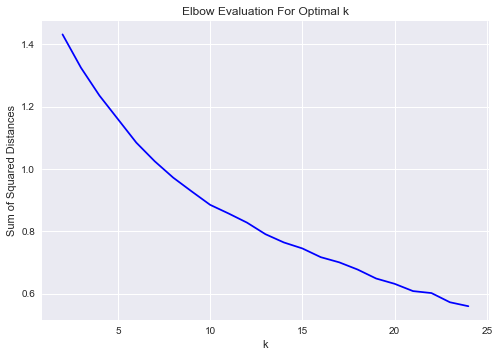

In [21]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# Sum of squared distances, for the elbow method
ssd = []

# Range of values for k
K = range(2,25)

for k in K:
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=10)
    kmeans = kmeans.fit(toronto_grouped_clustering)
    ssd.append(kmeans.inertia_)

# Generate a basic plot to help us decide on a value of k
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Evaluation For Optimal k')
plt.show()

Because there is no obvious elbow in the plot, I chose to perform some additional analysis to determine the optimum value for k. Silhouette analysis showed that the highest score was with two clusters, which is not only not very useful in practice, but is very telling about the similarity of the neighborhood venues in Toronto. For k in the range [2,25], the following table shows all the silhouette scores.

|  k | Silhouette Score   |  k | Silhouette Score   |  k | Silhouette Score   
|:---|:-------------------|:---|:-------------------|:---|:-------------------
| 2  | 0.6194163916554865 | 10 | 0.4938350153578033 | 18 | 0.4446661343470019
| 3  | 0.5784734639729774 | 11 | 0.4838643995091650 | 19 | 0.4394167476218801
| 4  | 0.5547995374828808 | 12 | 0.4760109511052501 | 20 | 0.4274931556533587
| 5  | 0.5379998968465072 | 13 | 0.4711670290641448 | 21 | 0.4305857899195751
| 6  | 0.5278579262415034 | 14 | 0.4645781080314445 | 22 | 0.4200639109904807
| 7  | 0.5163903471377527 | 15 | 0.4627725096303542 | 23 | 0.4119440513026273
| 8  | 0.5064161332012459 | 16 | 0.4579226829658905 | 24 | 0.4100717617543583
| 9  | 0.5026554531210757 | 17 | 0.4501693070049900 | 25 | 0.4064459562242892

Based on these scores, and the elbow plot, I'm choosing k to be 10 for this analysis.

In [22]:
# Run k-means clustering with the optimized values
kclusters = 10
kmeans = KMeans(n_clusters=kclusters, random_state=10)
kmeans = kmeans.fit(toronto_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 4, 9, 1, 7, 3, 5, 8, 2, 7])

In [23]:
# Add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.set_index('Neighborhood', inplace=True)

# Merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood.
# Note this is a lossy join, in that the initial data set includes some postal codes for 
# which we have no results (as discussed before).
# Note that on my versions, the join resulted in the cluster labels being converted to 
# float type, so I'm changing them back to int after the join
toronto_merged = pd.merge(joined, neighborhoods_venues_sorted, how='inner', 
                          left_on='Neighborhood', right_on='Neighborhood')
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

toronto_merged.head() 

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,1,Zoo Exhibit,Coffee Shop,Pharmacy,Fast Food Restaurant,Indian Restaurant,Pizza Place,Sandwich Place,Breakfast Spot,Park,Caribbean Restaurant
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,1,Zoo Exhibit,Coffee Shop,Pharmacy,Park,Gym,Liquor Store,Pub,Breakfast Spot,Fast Food Restaurant,Mexican Restaurant
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,1,Coffee Shop,Pharmacy,Park,Beer Store,Indian Restaurant,Pub,Bank,Breakfast Spot,Pizza Place,Gym
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1,Coffee Shop,Indian Restaurant,Gym,Pharmacy,Clothing Store,Caribbean Restaurant,Bank,Park,Pizza Place,Pub
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,4,Coffee Shop,Chinese Restaurant,Gym,Indian Restaurant,Pharmacy,Bookstore,Bakery,Sandwich Place,Caribbean Restaurant,Bank


Lets take a look at all of the clusters to see if these make sense.

##### Cluster 1

In [24]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,East Toronto,0,Park,Beach,Café,Pub,Coffee Shop,Bakery,Breakfast Spot,Bar,Indian Restaurant,Liquor Store
40,East York,0,Greek Restaurant,Café,Bakery,Park,Gastropub,Pizza Place,Brewery,Coffee Shop,Ice Cream Shop,Pub
41,East Toronto,0,Greek Restaurant,Café,Park,Bakery,Vietnamese Restaurant,Diner,Italian Restaurant,Pizza Place,American Restaurant,Gastropub
42,East Toronto,0,Café,Coffee Shop,Park,Beach,Brewery,Bakery,BBQ Joint,Breakfast Spot,Italian Restaurant,Indian Restaurant
43,East Toronto,0,Coffee Shop,Bakery,Café,Park,Bar,Vietnamese Restaurant,Italian Restaurant,Brewery,American Restaurant,Diner
51,Downtown Toronto,0,Café,Coffee Shop,Park,Restaurant,Diner,Pub,Bakery,Japanese Restaurant,Gastropub,Burger Joint
65,Central Toronto,0,Café,Restaurant,Italian Restaurant,Pizza Place,Ice Cream Shop,French Restaurant,Coffee Shop,Museum,Vegetarian / Vegan Restaurant,Mexican Restaurant
66,Downtown Toronto,0,Café,Bakery,Vegetarian / Vegan Restaurant,Thai Restaurant,Bookstore,Restaurant,Coffee Shop,Japanese Restaurant,Bar,Park
67,Downtown Toronto,0,Café,Bar,Vegetarian / Vegan Restaurant,Bakery,Vietnamese Restaurant,Dumpling Restaurant,Mexican Restaurant,Dessert Shop,Chinese Restaurant,Coffee Shop
68,Downtown Toronto,0,Park,Coffee Shop,Italian Restaurant,Café,Restaurant,Scenic Lookout,Gym,Dance Studio,Music Venue,Harbor / Marina


##### Cluster 2

In [25]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,1,Zoo Exhibit,Coffee Shop,Pharmacy,Fast Food Restaurant,Indian Restaurant,Pizza Place,Sandwich Place,Breakfast Spot,Park,Caribbean Restaurant
1,Scarborough,1,Zoo Exhibit,Coffee Shop,Pharmacy,Park,Gym,Liquor Store,Pub,Breakfast Spot,Fast Food Restaurant,Mexican Restaurant
2,Scarborough,1,Coffee Shop,Pharmacy,Park,Beer Store,Indian Restaurant,Pub,Bank,Breakfast Spot,Pizza Place,Gym
3,Scarborough,1,Coffee Shop,Indian Restaurant,Gym,Pharmacy,Clothing Store,Caribbean Restaurant,Bank,Park,Pizza Place,Pub
5,Scarborough,1,Coffee Shop,Pharmacy,Chinese Restaurant,Indian Restaurant,Burger Joint,Pizza Place,Park,Gym,Sandwich Place,Fast Food Restaurant
8,Scarborough,1,Coffee Shop,Sandwich Place,Park,Pharmacy,Grocery Store,Pizza Place,Clothing Store,Discount Store,Gym,Bank
16,Scarborough,1,Zoo Exhibit,Pharmacy,Coffee Shop,Sandwich Place,Fast Food Restaurant,Park,Pizza Place,Hakka Restaurant,Chinese Restaurant,Indian Restaurant
29,North York,1,Coffee Shop,Grocery Store,Pharmacy,Sandwich Place,Middle Eastern Restaurant,Pizza Place,Restaurant,Fast Food Restaurant,Breakfast Spot,Bank
31,North York,1,Coffee Shop,Pizza Place,Vietnamese Restaurant,Fast Food Restaurant,Sandwich Place,Pharmacy,Bank,Beer Store,Convenience Store,Athletics & Sports
33,North York,1,Coffee Shop,Pizza Place,Sandwich Place,Fast Food Restaurant,Bank,Hotel,Pharmacy,Restaurant,Burger Joint,Tennis Stadium


##### Cluster 3

In [26]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,Downtown Toronto,2,Coffee Shop,Café,Restaurant,Park,Italian Restaurant,Bakery,Theater,Breakfast Spot,Farmers Market,Bar
54,Downtown Toronto,2,Coffee Shop,Clothing Store,Restaurant,Cosmetics Shop,Tea Room,Café,Plaza,Gastropub,Bubble Tea Shop,Thai Restaurant
55,Downtown Toronto,2,Coffee Shop,Café,Restaurant,Hotel,Bakery,Italian Restaurant,Gastropub,Seafood Restaurant,Breakfast Spot,Cosmetics Shop
56,Downtown Toronto,2,Coffee Shop,Restaurant,Hotel,Café,Japanese Restaurant,Italian Restaurant,Park,Cocktail Bar,Pub,Bakery
58,Downtown Toronto,2,Café,Coffee Shop,Thai Restaurant,Steakhouse,American Restaurant,Asian Restaurant,Hotel,Sushi Restaurant,Bar,Theater
59,Downtown Toronto,2,Coffee Shop,Hotel,Café,Aquarium,Italian Restaurant,Brewery,Park,Scenic Lookout,Restaurant,Baseball Stadium
60,Downtown Toronto,2,Coffee Shop,Hotel,Café,American Restaurant,Restaurant,Deli / Bodega,Gastropub,Italian Restaurant,Thai Restaurant,Beer Bar
61,Downtown Toronto,2,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Gym,Seafood Restaurant,Steakhouse,Deli / Bodega,Gastropub
69,Downtown Toronto,2,Coffee Shop,Café,Restaurant,Italian Restaurant,Hotel,Pub,Bakery,Beer Bar,Cocktail Bar,Seafood Restaurant
70,Downtown Toronto,2,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Seafood Restaurant,Deli / Bodega,Asian Restaurant,Gastropub,Steakhouse


##### Cluster 4

In [27]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,North York,3,Coffee Shop,Restaurant,Café,Grocery Store,Korean Restaurant,Sushi Restaurant,Japanese Restaurant,Ramen Restaurant,French Restaurant,Arts & Crafts Store
52,Downtown Toronto,3,Coffee Shop,Burger Joint,Sushi Restaurant,Japanese Restaurant,Restaurant,Gay Bar,Bubble Tea Shop,Diner,Café,Dance Studio
57,Downtown Toronto,3,Coffee Shop,Café,Bubble Tea Shop,Burger Joint,Italian Restaurant,Clothing Store,Gym,Bar,Office,Thai Restaurant
85,Queen's Park,3,Coffee Shop,Sandwich Place,Café,Japanese Restaurant,Sushi Restaurant,Italian Restaurant,Burger Joint,Bubble Tea Shop,Gastropub,Gym


##### Cluster 5

In [28]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Scarborough,4,Coffee Shop,Chinese Restaurant,Gym,Indian Restaurant,Pharmacy,Bookstore,Bakery,Sandwich Place,Caribbean Restaurant,Bank
6,Scarborough,4,Coffee Shop,Burger Joint,Middle Eastern Restaurant,Park,Chinese Restaurant,Indian Restaurant,Supermarket,Pharmacy,Discount Store,Burrito Place
7,Scarborough,4,Coffee Shop,Sandwich Place,Burger Joint,Bank,Gym / Fitness Center,Clothing Store,Chinese Restaurant,Breakfast Spot,Middle Eastern Restaurant,Supermarket
10,Scarborough,4,Coffee Shop,Chinese Restaurant,Middle Eastern Restaurant,Sandwich Place,Supermarket,Pharmacy,Fast Food Restaurant,Indian Restaurant,Bookstore,Burger Joint
11,Scarborough,4,Coffee Shop,Middle Eastern Restaurant,Chinese Restaurant,Burger Joint,Grocery Store,Supermarket,Italian Restaurant,Mediterranean Restaurant,Electronics Store,Sandwich Place
12,Scarborough,4,Chinese Restaurant,Coffee Shop,Indian Restaurant,Clothing Store,Supermarket,Caribbean Restaurant,Pharmacy,Breakfast Spot,Restaurant,Bookstore
13,Scarborough,4,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Noodle House,Greek Restaurant,Restaurant,Caribbean Restaurant,Hakka Restaurant
17,North York,4,Coffee Shop,Bakery,Japanese Restaurant,Chinese Restaurant,Asian Restaurant,Caribbean Restaurant,Italian Restaurant,Burger Joint,Sushi Restaurant,Korean Restaurant
18,North York,4,Chinese Restaurant,Coffee Shop,Middle Eastern Restaurant,Bakery,Pharmacy,Burger Joint,Caribbean Restaurant,Seafood Restaurant,Asian Restaurant,Fast Food Restaurant
25,North York,4,Middle Eastern Restaurant,Coffee Shop,Burger Joint,Gym / Fitness Center,Café,Ice Cream Shop,Chinese Restaurant,American Restaurant,Japanese Restaurant,Supermarket


##### Cluster 6

In [29]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,North York,5,Coffee Shop,Korean Restaurant,Chinese Restaurant,Café,Sushi Restaurant,Furniture / Home Store,Supermarket,Grocery Store,Fast Food Restaurant,Burrito Place
21,North York,5,Korean Restaurant,Coffee Shop,Middle Eastern Restaurant,Sushi Restaurant,Café,Supermarket,Fast Food Restaurant,Bank,Steakhouse,Fried Chicken Joint
22,North York,5,Korean Restaurant,Coffee Shop,Grocery Store,Café,Burrito Place,Fried Chicken Joint,Ramen Restaurant,Sushi Restaurant,Sporting Goods Shop,Japanese Restaurant
24,North York,5,Korean Restaurant,Coffee Shop,Middle Eastern Restaurant,Café,Supermarket,Grocery Store,Sushi Restaurant,Wings Joint,Bubble Tea Shop,Fast Food Restaurant


##### Cluster 7

In [30]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Central Toronto,6,Coffee Shop,Italian Restaurant,Bakery,Sushi Restaurant,Park,Café,Diner,Japanese Restaurant,Pizza Place,Tea Room
45,Central Toronto,6,Coffee Shop,Italian Restaurant,Café,Sushi Restaurant,Indian Restaurant,Bakery,Park,Pizza Place,Japanese Restaurant,Gym
46,Central Toronto,6,Coffee Shop,Italian Restaurant,Café,Sushi Restaurant,Bakery,Pizza Place,Japanese Restaurant,Park,Dessert Shop,Tea Room
47,Central Toronto,6,Coffee Shop,Italian Restaurant,Café,Sushi Restaurant,Indian Restaurant,Bakery,Pizza Place,Gym,Park,Japanese Restaurant
48,Central Toronto,6,Italian Restaurant,Park,Sushi Restaurant,Café,Indian Restaurant,Grocery Store,Bakery,Coffee Shop,Dessert Shop,Spa
49,Central Toronto,6,Italian Restaurant,Café,Coffee Shop,Park,Sushi Restaurant,Middle Eastern Restaurant,Spa,Grocery Store,Deli / Bodega,Mexican Restaurant
50,Downtown Toronto,6,Coffee Shop,Park,Café,Italian Restaurant,Grocery Store,Indian Restaurant,Spa,Sushi Restaurant,Bar,Restaurant
63,Central Toronto,6,Coffee Shop,Italian Restaurant,Café,Bakery,Restaurant,Sporting Goods Shop,Japanese Restaurant,Gym,Trail,Bookstore
64,Central Toronto,6,Coffee Shop,Italian Restaurant,Sushi Restaurant,Trail,Café,Gastropub,Japanese Restaurant,Middle Eastern Restaurant,Bookstore,Convenience Store
73,York,6,Italian Restaurant,Coffee Shop,Bakery,Café,Park,Caribbean Restaurant,Bank,Breakfast Spot,Sushi Restaurant,Japanese Restaurant


##### Cluster 8

In [31]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 7, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Scarborough,7,Coffee Shop,Park,Beach,Pub,Breakfast Spot,Sandwich Place,Bank,Bakery,Burger Joint,Fast Food Restaurant
20,North York,7,Japanese Restaurant,Coffee Shop,Café,Gym,Restaurant,Burger Joint,Bank,Furniture / Home Store,Pharmacy,Supermarket
23,North York,7,Coffee Shop,Sushi Restaurant,Park,Café,Bakery,Burger Joint,Grocery Store,Sandwich Place,Tea Room,Ramen Restaurant
27,North York,7,Coffee Shop,Grocery Store,Restaurant,Japanese Restaurant,Gym / Fitness Center,Park,Middle Eastern Restaurant,Supermarket,Bike Shop,Movie Theater
35,East York,7,Coffee Shop,Grocery Store,Sandwich Place,Indian Restaurant,Middle Eastern Restaurant,Bank,Japanese Restaurant,Filipino Restaurant,Burger Joint,Gastropub
36,East York,7,Coffee Shop,Café,Bakery,Indian Restaurant,Sandwich Place,Gastropub,Brewery,Pharmacy,Pizza Place,Pakistani Restaurant
38,East York,7,Park,Grocery Store,Coffee Shop,Gym,Japanese Restaurant,Asian Restaurant,Café,Bakery,Indian Restaurant,Sushi Restaurant
39,East York,7,Bakery,Coffee Shop,Japanese Restaurant,Park,Gym,Grocery Store,Asian Restaurant,Sandwich Place,Liquor Store,Greek Restaurant
89,Etobicoke,7,Coffee Shop,Burger Joint,Furniture / Home Store,Café,Seafood Restaurant,Grocery Store,Breakfast Spot,Middle Eastern Restaurant,Burrito Place,Liquor Store
92,Etobicoke,7,Coffee Shop,Burger Joint,Italian Restaurant,Sushi Restaurant,Breakfast Spot,Bakery,Thai Restaurant,Grocery Store,Sandwich Place,Furniture / Home Store


##### Cluster 9

In [32]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 8, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,North York,8,Coffee Shop,Clothing Store,Vietnamese Restaurant,Deli / Bodega,Grocery Store,Boutique,Furniture / Home Store,Bagel Shop,Fried Chicken Joint,Sporting Goods Shop
32,North York,8,Clothing Store,Coffee Shop,Vietnamese Restaurant,Liquor Store,Sandwich Place,Fast Food Restaurant,Gym / Fitness Center,Sporting Goods Shop,Café,Chocolate Shop
62,North York,8,Coffee Shop,Clothing Store,Café,Bakery,Cosmetics Shop,Sporting Goods Shop,Sushi Restaurant,Bagel Shop,Toy / Game Store,Jewelry Store
71,North York,8,Clothing Store,Coffee Shop,Furniture / Home Store,Grocery Store,Bakery,Liquor Store,Falafel Restaurant,Sandwich Place,Burger Joint,Sporting Goods Shop
72,North York,8,Clothing Store,Coffee Shop,Furniture / Home Store,Bakery,Bagel Shop,Fast Food Restaurant,Caribbean Restaurant,Japanese Restaurant,Italian Restaurant,Boutique
79,North York,8,Clothing Store,Coffee Shop,Furniture / Home Store,Vietnamese Restaurant,Dessert Shop,Grocery Store,Sandwich Place,Fast Food Restaurant,Discount Store,Chocolate Shop


##### Cluster 10

In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 9, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Scarborough,9,Chinese Restaurant,Vietnamese Restaurant,Coffee Shop,Bubble Tea Shop,Japanese Restaurant,Korean Restaurant,Bakery,Tea Room,Dessert Shop,Sandwich Place
15,Scarborough,9,Chinese Restaurant,Bakery,Coffee Shop,Japanese Restaurant,Vietnamese Restaurant,Bubble Tea Shop,Tea Room,Dumpling Restaurant,Noodle House,Sandwich Place


Finally, we visualize our clusters

In [34]:
# Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# Set color scheme for the clusters. We are using the tab10 qualitative colormap
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.tab10(np.linspace(0, 1, len(ys)))
tab10 = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=tab10[cluster],
        fill=True,
        fill_color=tab10[cluster],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

### Conclusion

Going back the video in week 1, where the problem is posed as moving from West Toronto say, in North York (M9M) to East Toronto, say near Scarborough.  The clusters indicate that to find a similar neighborhood, you could choose between several, like Woborn (M1G) or Scarborough Village (M1J) and find the same amenities, relatively speaking, because these postal codes all belong to the same cluster (cluster 1).

Evaluation of the clusters revealed that we may not have the right value for k, or that we are possibly considering too many factors when building the clusters, because the scores for 2 vs 25 clusters were so similar, and no obvious elbow was shown in the evaluation of the squared distances. Other factors could help to distinguish similarity/dissimilarity, such as the rates and types of crime, locations of schools and places of worship, demographics of the neighborhood (e.g. mean age), availability of public transit, and housing costs could all be used to cluster these neighborhoods in addition to the available amenities. It should be noted that there are numerous Twitter hashtags corresponding to Toronto neighborhoods, streets, attractions and venues from which sentiment analysis could be performed and included.

#### A Note on Repeatability

Repeatability in data science is important. The reader should understand that even though the k-means clustering was performed using a specific value for the random seed that these exact results might not be perfectly repeatable. This is largely because we are using a crowd-sourced data provider for location data, and that over time the details returned by that provider may change for many reasons, not the least of which is what venues exist in any given location at any given time.

#### Bibliography

The following sources were used in the creation of this notebook.
* [Foursquare API](https://developer.foursquare.com/docs)
* [K-Means Cluster Analysis, UC Business Analytics](https://uc-r.github.io/kmeans_clustering)
* [K-Means Clustering Lab Notebook](https://labs.cognitiveclass.ai/tools/jupyterlab/lab/tree/labs/DP0701EN/DP0701EN-3-3-1-Clustering-k-means-py-v1.0.ipynb)
* [Toronto Twitter Hashtags](http://indxto.com/)
* [Silhouette analysis Example](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
* [Silhouette Results](https://github.com/jrfoster/Coursera_Capstone/blob/master/Week3_Silhouette_Analysis.ipynb)
